In [57]:
%run DFFunctions.ipynb

import numpy as np
import scipy as sc
import sympy
from matplotlib import pyplot as plt
from matplotlib import patheffects
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sympy.tensor.array import Array
import time
from sklearn.utils import shuffle

# Задание формул символьным типом (при помощи sympy)
xs = [sympy.Symbol('x'+str(i)) for i in range(2)]
f = 2 * xs[0]**2 + xs[0]*xs[1] - xs[1]**2
f = xs[0]**2 + xs[1]**2
f = xs[0]**2 + xs[1]**2 + 4 * xs[0] * xs[1]
f

f, sx = P4MultiSym()

In [58]:
def get_fn_resultSingle(df, x0):
    ''' 
        Вернуть числовой результат частных производных символьно заданной функции для одного параметра x,y
        df - массив частных производных функции
        x0 - массив входных данных [x, y]
    '''
    variables = [(xs[i], x0[i]) for i in range(len(xs))] # -> [(x0, 1.0), (x1, 2.0)]
    return np.double(df.subs(variables))

# get_fn_resultSingle(df, np.array([1., 2.]))

In [59]:
XX = np.linspace(-25, 25, 100)
YY = np.linspace(-25, 25, 100)

In [60]:
def get_fn_result(df, x0):
    ''' 
        Вернуть числовой результат частных производных символьно заданной функции 
        df - массив частных производных функции
        x0 - матрица входных данных [[x1,y1], [x2,y2]]
    '''
    r = []
    for x_el in x0:
        d_r = []
        for i,_ in enumerate(xs):
            s = df[i].subs(xs[i], x_el[i])
            d_r.append(s)
        r.append(d_r)
    return r

def grad_descent(f, z0, with_history=False, atype="constant", lr=1e-2, eps=1e-06): 
    ''' 
        Градиентный спуск для символьно заданной ф-ии
        f - функция
        z0 - исходный массив точек X,Y
        with_history - результат вернется вместе с промежуточными расчетами
        atype - тип алгоритма
            * constant - постоянный learning rate
            * inertion - lr изменяется по формуле lr = 1r0 / min(i + 1, mn) 
        lr - learning rate
        eps - критерий остановки перебора epsilon 
    '''
    df = Array([sympy.diff(f, x) for x in xs]) # Частные производные символьно заданной функции f
    history = []
    
    if atype == "constant":
        while True:
            z0 = z0 - lr * get_fn_resultSingle(df, z0)
            history.append(z0)
            norm = np.linalg.norm(get_fn_resultSingle(df, z0))
            if norm < eps:
                break
    elif atype == "inertion":
        idx = 1
        mn = 10
        lr0 = lr
        while True:
            lr = 0.1 / min((1 + idx), mn)
            idx+=1
            
            z0 = z0 - lr * get_fn_resultSingle(df, z0)
            history.append(z0)
            norm = np.linalg.norm(get_fn_resultSingle(df, z0))
            if norm < eps:
                break
    elif atype == "stohastic-backup":
        #. Стохастический градиентный спуск
        epoches = 100
        batch_size = 2
        z0_prev = z0
        z0_new = z0
        shuffled = shuffle(z0, random_state=0)
        
        # Итерация по батчам
        def next_batch(z0, batch_size):
            for i in range(0, z0.shape[0], batch_size):
                yield(z0[i:i+batch_size])
        
#         print(next_batch(shuffled, batch_size))
        
        for epoch in range(epoches):
            for batch in next_batch(shuffled, batch_size):
                z0_prev = z0_new    
                z0_new_n = get_fn_resultSingle(df, z0_prev)
                z0_new = z0_prev - lr * get_fn_resultSingle(df, batch)
                history.append(z0_new)
                
    elif atype == "stohastic":
        #. Стохастический градиентный спуск
        epoches = 100
        batch_size = 6
        z0_prev = z0
        z0_new = z0
        XX_shuffled, YY_shuffled = shuffle(XX, YY, random_state=0)
        
        # Итерация по батчам
        def next_batch(X_, Y_, batch_size):
            for i in range(0, X_.shape[0], batch_size):
                yield( X_[i:i + batch_size], Y_[i:i + batch_size] )
        
        for epoch in range(epoches):
            XX_shuffled, YY_shuffled = shuffle(XX_shuffled, YY_shuffled, random_state=0)
            
            # А как использовать то эти батчи????
            for (batchX, batchY) in next_batch(XX_shuffled, YY_shuffled, batch_size):
                z0_prev = z0_new  
                z0_new = z0_prev - lr * get_fn_resultSingle(df, z0_prev)
                
#                 print("batchX", batchX)
#                 print("\nbatchY", batchY)
#                 return 1,2
                
#                 z0_new = z0_prev - lr * get_fn_resultSingle(df, batch)
                history.append(z0_new)
        
        z0 = z0_new
        
    # Если нужно вернуть с историей
    if with_history:
        return np.array(history), z0
    else:
        return z0

In [61]:
# start_time = time.time()
# history, best = grad_descent(f, np.array([1., 2.]), True, "constant")
# print("> Время выполнения алгоритма constant %s sec " % (time.time() - start_time))
# print("Точка минимума:", best, "\n")

# start_time = time.time()
# history, best = grad_descent(f, np.array([1., 2.]), True, "inertion")
# print("> Время выполнения алгоритма inertion %s sec " % (time.time() - start_time))
# print("Точка минимума:", best, "\n")

start_time = time.time()
history, best = grad_descent(f, np.array([1., 2.]), True, "stohastic")
print("> Время выполнения алгоритма [stohastic] %s sec " % (time.time() - start_time))
print("Точка минимума:", best, "\n")

> Время выполнения алгоритма [stohastic] 6.9703919887542725 sec 
Точка минимума: [0.88215912 1.9646568 ] 



In [62]:
print("История: \n\n", history)
print("\nТочка минимума:", best)

История: 

 [[0.87433629 1.74867259]
 [0.88525231 1.9682199 ]
 [0.88087699 1.74423713]
 ...
 [0.88215912 1.9646568 ]
 [0.88215912 1.74601982]
 [0.88215912 1.9646568 ]]

Точка минимума: [0.88215912 1.9646568 ]


In [63]:
# Data
xrange = np.linspace(-25, 25, 200)
yrange = np.linspace(-25, 25, 200)
X,Y = np.meshgrid(xrange, yrange)

Z = X

for i in range(len(xrange)):
    for j in range(len(yrange)):
        xx0 = X[i,j]
        xx1 = Y[i,j]
        Z[i,j] = f.subs({xs[0]:xx0, xs[1]:xx1})

In [64]:
X,Y = np.meshgrid(xrange, yrange) #Почему-то перезаписываются массивы, поэтому дублирую

# Теоретически заданный график
ft = lambda x: x[0]**2 + x[1]**2 # функция
ft = lambda x: x[0]**2 + x[1]**2 + 4 * x[0] * x[1] # функция
Zt = ft([X,Y])
print(Zt)

# Координаты экспериментально найденной точки минимума
bx = best[0]
by = best[1]
bz = f.subs({xs[0]:bx, xs[1]:by})

[[ 3750.          3712.37468751  3674.87563445 ... -1224.62185298
  -1237.37405621 -1250.        ]
 [ 3712.37468751  3675.00189389  3637.75535971 ... -1212.50094695
  -1225.0006313  -1237.37405621]
 [ 3674.87563445  3637.75535971  3600.76134441 ... -1200.25378147
  -1212.50094695 -1224.62185298]
 ...
 [-1224.62185298 -1212.50094695 -1200.25378147 ...  3600.76134441
   3637.75535971  3674.87563445]
 [-1237.37405621 -1225.0006313  -1212.50094695 ...  3637.75535971
   3675.00189389  3712.37468751]
 [-1250.         -1237.37405621 -1224.62185298 ...  3674.87563445
   3712.37468751  3750.        ]]


Text(0.5, 0, 'z')

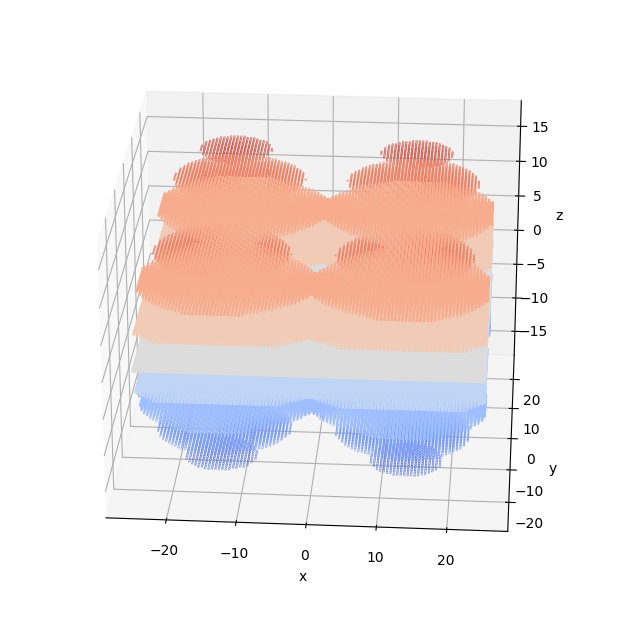

In [72]:
fig = plt.figure(figsize=(8, 8), dpi=100)
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 10, cmap=cm.coolwarm)

ax.view_init(25, -86)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

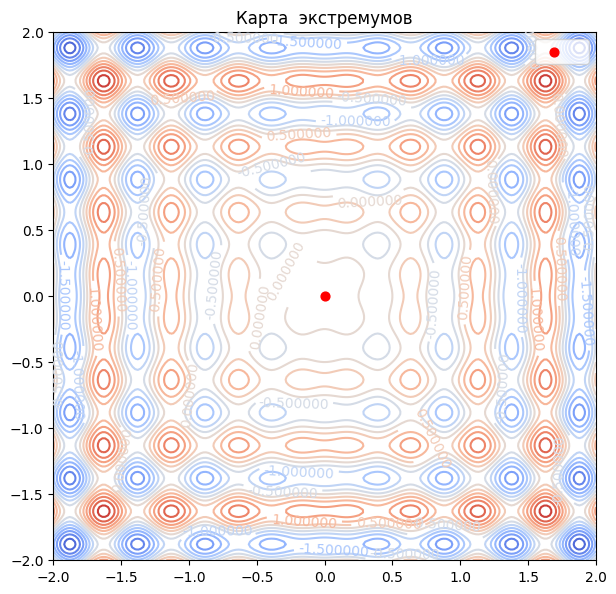

In [71]:
fig, ax = plt.subplots(figsize=(7, 7), dpi=100)
        
p4XRange = np.linspace(-2, 2, 200)
p4YRange = np.linspace(-2, 2, 200)
p4X,p4Y = np.meshgrid(p4XRange, p4YRange)


CS = ax.contour(*np.meshgrid(p4XRange, p4YRange), 
                P4Multi(p4X, p4Y),
                levels = 15,
#                     colors=[(0, 0, 0)] * 15,
                cmap=cm.coolwarm
               )

ax.clabel(CS, fmt="%1f", use_clabeltext=True)

ax.scatter(0, 0, c='red', s=40, label=" ",)
ax.set_title("Карта  экстремумов")

plt.legend()
plt.show()

KeyboardInterrupt: 

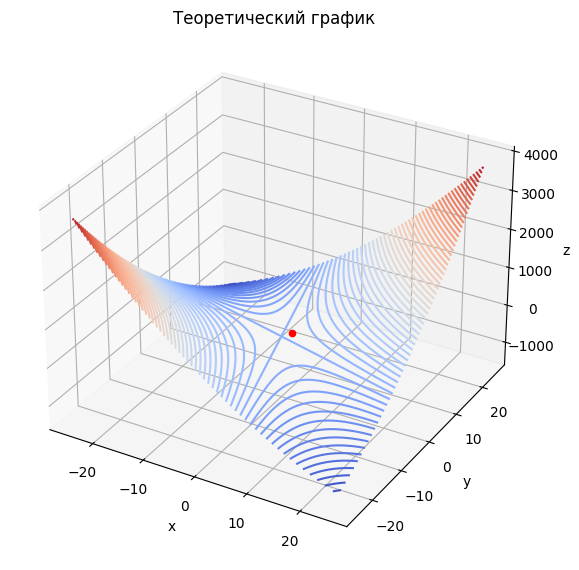

Error in callback <function flush_figures at 0x7fc633ac2c10> (for post_execute):


KeyboardInterrupt: 

In [70]:
draw3DGDots(X,Y,Zt, [[bx,by,bz]], "Теоретический график")
draw3DGDots(X,Y,Z, [[bx,by,bz]], "Экспериментальный график")